# Logistic 回归
Logistic回归中，输出(Y = 1)的对数几率是输入 x 的线性函数，思路 : 

1. 先拟合决策边界（不局限于线性，还可以是多项式）
2. 再建立这个边界和分类概率的关系
3. 从而得到二分类情况下的概率

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable

In [95]:

with open('data.txt') as f :
    data = f.read().split('\n')
    data = [row.split(',') for row in data][:-1]
  
    x0 = np.array([(float(row[0]), float(row[1])) for row in data if row[2] == '0'])
    x1 = np.array([(float(row[0]), float(row[1])) for row in data if row[2] == '1'])
    y0 = np.array([float(row[2]) for row in data if row[2] == '0'])
    y1 = np.array([float(row[2]) for row in data if row[2] == '1'])
#x0, y0 = label0[:, 0], label0[:, 1]
#x1, y1 = label1[:, 0], label1[:, 1]
x0 = torch.from_numpy(x0).float()
x1 = torch.from_numpy(x1).float()
y0 = torch.from_numpy(y0).float()
y1 = torch.from_numpy(y1).float()
# 注意 x, y 数据的数据形式是一定要像下面一样 (torch.cat 是在合并数据)
x = torch.cat((x0, x1), 0).type(torch.FloatTensor)  # FloatTensor = 32-bit floating
y = torch.cat((y0, y1), 0).type(torch.FloatTensor)    # LongTensor = 64-bit integer
print(x,y)
#plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.data.numpy(), lw=0, cmap='RdYlGn')
#plt.show()

tensor([[34.6237, 78.0247],
        [30.2867, 43.8950],
        [35.8474, 72.9022],
        [45.0833, 56.3164],
        [95.8616, 38.2253],
        [75.0137, 30.6033],
        [39.5383, 76.0368],
        [67.9469, 46.6786],
        [67.3720, 42.8384],
        [50.5348, 48.8558],
        [34.2121, 44.2095],
        [93.1144, 38.8007],
        [61.8302, 50.2561],
        [38.7858, 64.9957],
        [52.1080, 63.1276],
        [40.2369, 71.1677],
        [54.6351, 52.2139],
        [33.9155, 98.8694],
        [74.7893, 41.5734],
        [34.1836, 75.2377],
        [51.5477, 46.8563],
        [82.3688, 40.6183],
        [51.0478, 45.8227],
        [62.2227, 52.0610],
        [34.5245, 60.3963],
        [50.2865, 49.8045],
        [49.5867, 59.8090],
        [32.5772, 95.5985],
        [35.2861, 47.0205],
        [56.2538, 39.2615],
        [30.0588, 49.5930],
        [44.6683, 66.4501],
        [66.5609, 41.0921],
        [49.0726, 51.8832],
        [32.7228, 43.3072],
        [60.4556, 42

In [96]:
# 定义模型

class logisticRegression(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.line = nn.Linear(2, 1)
        self.smd = nn.Sigmoid()
    def forward(self, x) :
        x = self.line(x)
        return self.smd(x)

logistic = logisticRegression()

if torch.cuda.is_available() :
    logistic.cuda()

In [97]:
# 定义损失函数为二分类交叉熵(Binary Cross Entropy)
criterion = nn.BCELoss()
# 定义优化函数为随机梯度下降(Sochastic Gradient Descent)
optimizer = optim.SGD(logistic.parameters(), lr = 1e-3, momentum = 0.9)

解释一下两个部分

#### BCELoss()
它的定义是 $loss(o, t) = \frac 1 n \sum_i(t[i] * log(o[i]) + (1 - t[i]) * log(1 - o[i]))$

以上来源于[torch.nn.BCELoss](http://pytorch.org/docs/master/nn.html?highlight=nn%20bceloss#torch.nn.BCELoss)
#### SGD函数，它带有一个参数 `momentum = 0.9`，这表示动量。

这种优化方法来源于[On the importance of initialization and momentum in deep learning](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf)

它的优化方式为 : $$v = \rho * v + g \\ p = p - lr * v$$
其中，p, g, v, $\rho$ 分别表示待更新的参数parameters，求得的梯度gradient，速度velocity，和动量momentum

以上来源于[官网](http://pytorch.org/docs/master/optim.html)关于torch.optim.SGD的note

In [100]:
# 开始训练
epoches = 50000
for epoch in range(epoches) :
    if torch.cuda.is_available() :
        x_data = Variable(x).cuda()
        y_data = Variable(y).cuda()
    else :
        x_data = Variable(x)
        y_data = Variable(y)
    
    # forward 前向计算
    out = logistic(x_data)
    loss = criterion(out, y_data)
    
    # 计算准确率
    print_loss = loss.item()
    mask = out.ge(0.5).float()
    # print('size : {} - {}'.format(mask.size(), y.size()))
    correct = (mask == y_data).sum()
    acc = correct.item() / x_data.size(0)
    
    # BP回朔
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10000 == 0 :
        print('*' * 10)
        print('epoch {}'.format(epoch + 1))
        print('loss is {:.4f}'.format(print_loss))
        print('correct rate is {:.4f}'.format(acc))


**********
epoch 10000
loss is 11.0524
correct rate is 60.0000
**********
epoch 20000
loss is 11.0524
correct rate is 60.0000
**********
epoch 30000
loss is 11.0524
correct rate is 60.0000
**********
epoch 40000
loss is 11.0524
correct rate is 60.0000
**********
epoch 50000
loss is 11.0524
correct rate is 60.0000


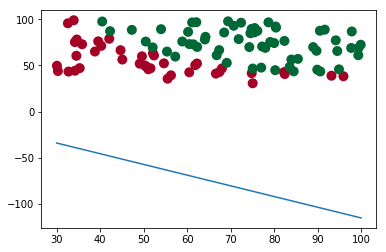

In [99]:
w0, w1= logistic.line.weight[0]
w0 = float(w0.item())
w1 = float(w1.item())
b = float(logistic.line.bias.item())

plot_x = np.arange(30, 100, 0.1)
plot_y = (-w0 * plot_x - b) / w1


plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.data.numpy(), s=100, lw=0, cmap='RdYlGn')
plt.plot(plot_x, plot_y)
plt.show()